Import Games of Elo ~1100

In [1]:
import pandas as pd 
import torch 
from torch.utils.data import Dataset
import dask.dataframe as dd 
import numpy as np
import torch.nn as nn
import math
import chess
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
grouped_df = pd.read_csv("haha_longer.csv")
print(grouped_df)

        game_id                                              moves  white_elo  \
0      001QYJhZ  d2d4 f7f6 c2c4 e7e5 d4e5 f6e5 e2e3 b8c6 b1c3 f...       1127   
1      0073Uoft  e2e4 e7e5 g1f3 b8c6 f1c4 g8f6 f3g5 d7d5 g5f7 e...       1142   
2      008AlITg  e2e4 e7e5 g1f3 b8c6 b1c3 g8f6 f3e5 f8b4 e5c6 d...       1187   
3      00911g2y  e2e4 d7d5 e4d5 d8d5 g1f3 d5a5 b1c3 g8f6 d2d4 c...       1135   
4      00A6eGbe  b2b4 e7e5 c1b2 g8f6 b2e5 b8c6 e5c3 d7d5 d2d4 f...       1112   
...         ...                                                ...        ...   
99290  zzo2DSPt  d2d4 g8f6 c1f4 g7g6 g1f3 f8g7 b1c3 e8g8 e2e3 d...       1141   
99291  zzo5kmuO  e2e4 e7e5 g1f3 d7d6 b1c3 c8g4 f1e2 g4f3 e2f3 d...       1112   
99292  zztPJDK8  e2e4 c7c5 g1f3 b8c6 f1c4 e7e6 d2d3 d7d5 e4d5 e...       1178   
99293  zzx4qVJx  e2e3 d7d5 f2f4 g8f6 b2b3 e7e6 c1b2 f6e4 g2g4 d...       1197   
99294  zzxkXY9h  d2d4 d7d5 g1f3 g8f6 c1f4 b8c6 e2e3 c8f5 f1b5 f...       1140   

       black_elo  white_act

In [3]:
piece_to_index = {
    'p' : 0,
    'r' : 1,
    'b' : 2,
    'n' : 3,
    'q' : 4,
    'k' : 5,
}


def string_to_array(string):
    rows = string.split("/")
    ans = [[[0 for a in range(8)] for b in range(8)] for c in range(6)]
    for row in range(8):
        curr_row = rows[row]
        #print(curr_row)
        offset = 0
        for piece in range(len(curr_row)):
            curr_piece = curr_row[piece]
            sign = 1 if curr_piece.lower() == curr_piece else -1 # check if the piece is capitalized
            curr_piece = curr_piece.lower() # after storing whether or not capitalized, standardize it to lower case for easy processing
            if curr_piece not in piece_to_index.keys():
                offset += int(curr_piece) - 1
            else:
                current_board = ans[piece_to_index[curr_piece]]
                current_board[row][offset + piece] = 1 * sign
                ans[piece_to_index[curr_piece]] = current_board
    return ans

def string_to_array_two(string):
    rows = string.split("/")
    # Adjusted to 12 to account for separate layers for black and white pieces of each type
    ans = [[[0 for a in range(8)] for b in range(8)] for c in range(12)]
    # Mapping for pieces to their respective index in the 12 layer array
    # White pieces are in the first 6 layers and black pieces in the last 6 layers
    piece_to_index = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5,
                      'P': 6, 'R': 7, 'N': 8, 'B': 9, 'Q': 10, 'K': 11}

    for row in range(8):
        curr_row = rows[row]
        offset = 0
        for piece in range(len(curr_row)):
            curr_piece = curr_row[piece]
            if curr_piece not in piece_to_index.keys():
                offset += int(curr_piece) - 1
            else:
                current_board = ans[piece_to_index[curr_piece]]
                current_board[row][offset + piece] = 1
                ans[piece_to_index[curr_piece]] = current_board

    return ans

""" This vocabulary is simply to turn the labels (predicted move) into integers which PyTorch Models can understand"""
class Vocabulary:
    def __init__(self):
        self.move_to_id = {"<UNK>": 0}
        self.id_to_move = {0: "<UNK>"}
        self.index = 1  # Start indexing from 1

    def add_move(self, move):
        if move not in self.move_to_id:
            self.move_to_id[move] = self.index
            self.id_to_move[self.index] = move
            self.index += 1

    def get_id(self, move):
        return self.move_to_id.get(move, self.move_to_id["<UNK>"])

    def get_move(self, id):
        return self.id_to_move.get(id, self.id_to_move[0])

class ChessDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features, label = self.X[idx], self.Y[idx]
        
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [4]:
def df_to_data(df, sampling_rate=1, algebraic_notation=True):
    """
    Input: Dataframe of training data in which each row represents a full game played between players
    Output: List in which each item represents some game's history up until a particular move, List in the same order in which the associated label is the following move
    """
    board_states = []
    next_moves = []
    vocab = Vocabulary()
    chess_board = chess.Board()
    for game_board, game_moves in zip(df['board'],df['moves']):
        moves = game_moves.split()
        boards = game_board.split('*')
        # Encode the moves into SAN notation and then into corresponding indices
        encoded_moves = []
        for move in moves:
            # Create a move object from the coordinate notation
            move_obj = chess.Move.from_uci(move)
            if move_obj not in chess_board.legal_moves:
                break 
            else:
                if algebraic_notation:
                    algebraic_move = chess_board.san(move_obj)
                    chess_board.push(move_obj)
                    vocab.add_move(algebraic_move)
                    encoded_move = vocab.get_id(algebraic_move)
                    encoded_moves.append(encoded_move)
                else:
                    encoded_move = vocab.get_id(move)
                    encoded_moves.append(encoded_move)
        chess_board.reset()
        boards = boards[:len(encoded_moves)]
        # Now generate X,Y with sampling
        for i in range(len(encoded_moves)-1):
            #TODO: Figure out how to deal with black orientation 'seeing' a different board
            if random.uniform(0, 1) <= sampling_rate and 'w' in boards[i]:
                label = encoded_moves[i+1]
                board_states.append(string_to_array(boards[i].split(' ')[0]))
                next_moves.append(label)

    return board_states, next_moves, vocab

In [5]:
trainX, trainY, vocab = df_to_data(grouped_df, sampling_rate=0.75)

In [6]:
print(len(vocab.id_to_move.keys()))
print(torch.tensor(trainX[0]).shape)
print(trainX[0])

5690
torch.Size([6, 8, 8])
[[[0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1], [0, 0, 0, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0, 0, -1]], [[0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, -1, 0, 0, -1, 0, 0]], [[0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, -1, 0, 0, 0, 0, -1, 0]], [[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 

In [7]:
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer


In [29]:
class ChessViT(nn.Module):
    def __init__(self, d_out, patch_size=64, emb_size=64, nheads=8, num_encoder_layers=4, dropout=0.1):
        super(ChessViT, self).__init__()

        # Project each 8 by 8 channel to the embedding size
        self.patch_to_emb = nn.Linear(patch_size, emb_size)
        
        # Positional encoding
        self.pos_emb = nn.Parameter(nn.Parameter(self.generate_sin_cos_pos_emb(6 + 1, emb_size), requires_grad=False))  # +1 for class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))

        # Transformer
        encoder_layers = TransformerEncoderLayer(emb_size, nheads, dim_feedforward=emb_size*4, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_encoder_layers)

        self.fc = nn.Sequential(nn.Linear(emb_size, emb_size),
                                nn.ReLU(), 
                                nn.Linear(emb_size,d_out)
                                )

    def generate_sin_cos_pos_emb(self, length, emb_size):
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2) * -(np.log(10000.0) / emb_size))
        pe = torch.zeros(1, length, emb_size)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        return pe
    
    def forward(self, x):
        # x shape: (batch_size, channels, height, width), expected: (batch_size, 6, 8, 8)

        # Flatten patches and project to embedding size
        x = x.view(x.size(0), 6, -1)  # reshape to (batch_size, 6, 64)
        x = self.patch_to_emb(x)  # (batch_size, 6, emb_size)

        # Add class token
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)  # (batch_size, 1, emb_size)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, 7, emb_size)
        # Add positional encoding

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Use class token or mean pooling
        x = x[:, 0, :]  # Class token representation
        x = self.fc(x)
        return x

In [11]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel

Functions for training

In [16]:
# Function to calculate top-3 accuracy
def top_3_accuracy(y_true, y_pred):
    top3 = torch.topk(y_pred, 3, dim=1).indices
    correct = top3.eq(y_true.view(-1, 1).expand_as(top3))
    return correct.any(dim=1).float().mean().item()

def train(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    swa_model = AveragedModel(model)
    swa_start = 1
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        # Training
        model.train()
        count = 0
        for sequences, labels in train_loader:
            count += 1
            sequences, labels = sequences.to(device), labels.to(device)
            # Forward Pass
            output = model(sequences)
            loss = criterion(output, labels)
            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # For logging purposes
            training_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count}')
        if epoch >= swa_start:
            swa_model.update_parameters(model)
        torch.optim.swa_utils.update_bn(train_loader, swa_model)
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        validation_loss = 0.0
        if val_loader is not None:
            with torch.no_grad():
                val_correct = 0
                val_total = 0
                val_top3_correct = 0
                validation_loss = 0

                for sequences, labels in val_loader:
                    sequences, labels = sequences.to(device), labels.to(device)
                    outputs = model(sequences)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_top3_correct += top_3_accuracy(labels, outputs) * labels.size(0)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

                val_loss_values.append(validation_loss / len(val_loader))
                val_accuracy = 100 * val_correct / val_total
                val_top3_accuracy = 100 * val_top3_correct / val_total
                val_error.append(100 - val_accuracy)
                val_3_accuracy.append(val_top3_accuracy)

        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        for op_params in optimizer.param_groups:
            op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values, swa_model

Now let's train

In [9]:
dataset = ChessDataset(trainX, trainY)
# Calculate split sizes
total_size = len(dataset)
print(total_size)

1721064


## Experiment 1 

In [30]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 5
d_out = len(vocab.id_to_move.keys())
model = ChessViT(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1635010
578618


Epoch 1, Batch: 1000| Training Loss: 5.676787749767303
Epoch 1, Batch: 2000| Training Loss: 5.573584450244904
Epoch 1, Batch: 3000| Training Loss: 5.527074258645375
Epoch 1, Batch: 4000| Training Loss: 5.493521292209625
Epoch 1, Batch: 5000| Training Loss: 5.464375877189636
Epoch 1, Batch: 6000| Training Loss: 5.441668418884277
Epoch 1, Batch: 7000| Training Loss: 5.42562003837313
Epoch 1, Batch: 8000| Training Loss: 5.4084956629872325
Epoch 1, Batch: 9000| Training Loss: 5.396536246882545
Epoch 1, Batch: 10000| Training Loss: 5.384719434404373
Epoch 1, Batch: 11000| Training Loss: 5.37524363079938
Epoch 1, Batch: 12000| Training Loss: 5.363318127036095
Epoch 1, Batch: 13000| Training Loss: 5.3526164914277885
Epoch 1, Batch: 14000| Training Loss: 5.342617361852101
Epoch 1, Batch: 15000| Training Loss: 5.332624121030172
Epoch 1, Batch: 16000| Training Loss: 5.32491182950139
Epoch 1, Batch: 17000| Training Loss: 5.316313797137316
Epoch 1, Batch: 18000| Training Loss: 5.309362126403385
Ep

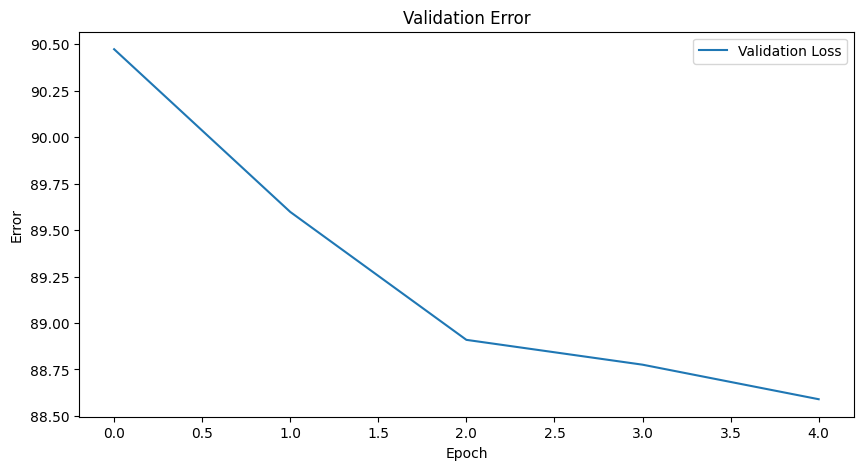

<Figure size 640x480 with 0 Axes>

In [31]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image